지금까지 우리는 데이터가 가진 속성을 특성이라 불렀다. 앞서 다루었던 과일 사진의 경우 100*100개의 픽셀이 있기 때문에 10000개의 특성을 지닌 셈이다.<br/> 머신러닝에서는 이런 특성을 차원(dimension)이라고도 부른다. 만약 이 차원을 줄일 수 있다면 저장 공간을 크게 절약 할 수 있을것이다. 이를 위해 비지도 학습 작업 중 하나인 차원 축소(dimensionality reduction) 알고리즘 중 대표적인 알고리즘인 주성분 분석(principal component alalysis, PCA)를 사용해보자.

In [1]:
#과일 사진 데이터 준비
!wget https://bit.ly/fruits_300 -O fruits_300.npy
import numpy as np

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

--2021-05-27 14:26:54--  https://bit.ly/fruits_300
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hongong-ml/raw/master/fruits_300.npy [following]
--2021-05-27 14:26:54--  https://github.com/rickiepark/hongong-ml/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hongong-ml/master/fruits_300.npy [following]
--2021-05-27 14:26:54--  https://raw.githubusercontent.com/rickiepark/hongong-ml/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443..

In [2]:
#PCA 분석 알고리즘 사용
from sklearn.decomposition import PCA
pca = PCA(n_components=50)      #n_components 매개변수에 찾을 주성분의 개수를 지정
pca.fit(fruits_2d)      #비지도 학습이기 때문에 fit()매서드에 타깃값을 제공하지 않음
print(pca.components_.shape)      #PCA클래스가 찾은 주성분은 components_ 속성에 저장됨

(50, 10000)


In [8]:
#3차원 배열을 입력받아 이미지를 그리는 함수를 정의함
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
  n = len(arr)
  rows = int(np.ceil(n/10))
  cols = n if rows < 2 else 10
  fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)
  for i in range(rows):
    for j in range(cols):
      if i*10 + j < n:
        axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
      axs[i, j].axis('off')
  plt.show()

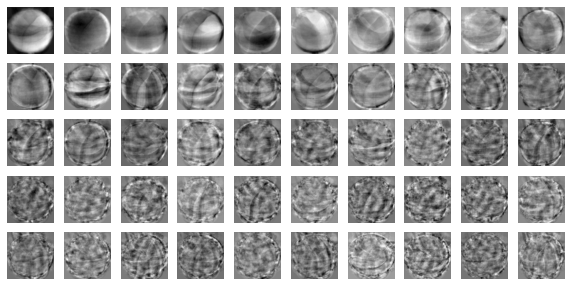

In [7]:
#pca.components_ 배열의 첫번째 차원(주성분의 개수)이 50, 두번째 차원(주성분이 지닌 특성)이 10000이므로 주성분들을 100 * 100 크기의 이미지로 그려볼 수 있다.
draw_fruits(pca.components_.reshape(-1, 100, 100))

In [9]:
#데이터 원본의 크기 확인
print(fruits_2d.shape)

(300, 10000)


In [11]:
#50개의 주성분을 가진 PCA모델을 사용해 원본을 (300, 50)크기로 변환
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


In [13]:
#줄여뒀던 특성을 inverse_transform() 메서드를 통해 복원
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


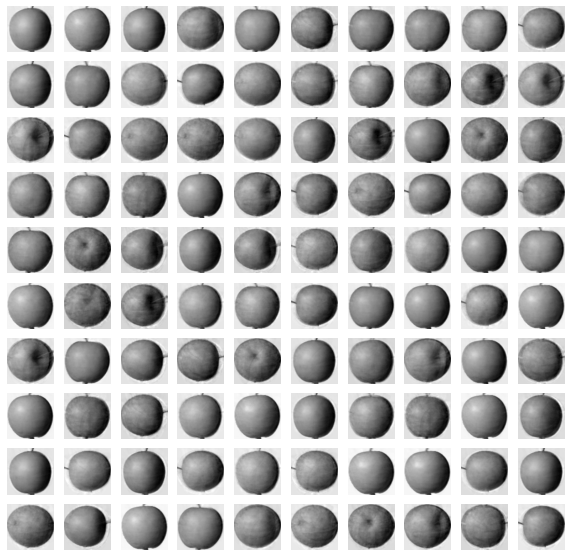

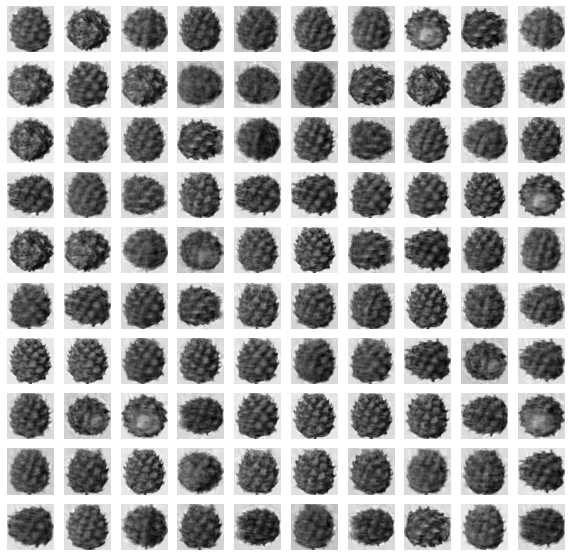

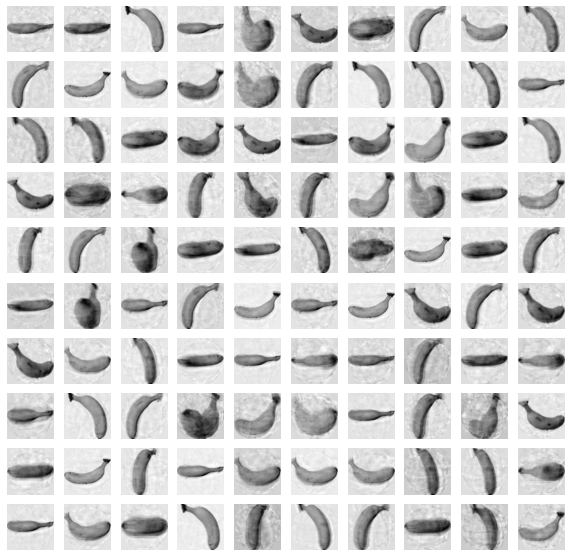

In [14]:
#복원한 데이터를 그려봄
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:     #100개씩 나누어 출력
  draw_fruits(fruits_reconstruct[start:start+100])
  print("\n")

출력 결과 복원이 잘 이루어졌음을 확인할 수 있었다. 50개의 주성분이 분산을 가장 잘 보존하도록 변환된 것이기 때문이다.<br/>
주성분이 원본데이터의 분산을 얼마나 잘 나타내는지 기록한 값을 설명된 분산(explained variance)이라고 한다. PCA 클래스의 explained_variance_ratio_에 각 주성분의 설명된 분산 비율이 기록되어 있다. 당연하게도 첫번째 주성분의 설명된 분산이 가장 크다.<br/>
이 분산 비율을 모두 더하면 50개의 주성분으로 표현하고 있는 총 분산 비율을 얻을 수 있다.

In [15]:
print(np.sum(pca.explained_variance_ratio_))

0.9215185033223233


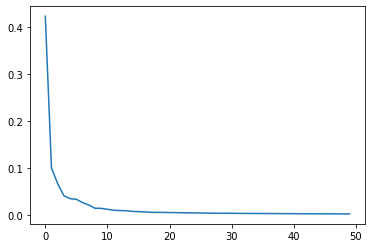

In [16]:
#설명된 분산의 비율을 그래프로 그려보면 적절한 주성분의 개수를 찾는 데 도움이 된다.
plt.plot(pca.explained_variance_ratio_)
plt.show()      #처음 10개의 주성분이 대부분의 분산을 표현하고 있는것을 확인.

In [17]:
#로지스틱 회귀와의 비교를 위해 로지스틱 회귀 모델 시행
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
target = np.array([0]*100 + [1]*100 + [2]*100)      #첫 100개는 사과, 다음 100개는 파인애플, 마지막 100개는 바나나.

from sklearn.model_selection import cross_validate      #교차검증시행

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))      #교차검증 점수
print(np.mean(scores['fit_time']))      #훈련시간

0.9966666666666667
1.4966683864593506


In [18]:
#PCA로 축소한 fruits_pca를 사용하여 교차검증
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.03150253295898438


비교 결과 50개의 특성을 사용했는데도 정확도가 100%고 시간 또한 감소된 것을 확인할 수 있다.<br/>
앞서 PCA클래스를 사용할 떄 n_components 매개변수를 통해 주성분의 개수를 지정했었다. 이번에는 그 대신 원하는 설명된 분산의 비율을 통해 주성분의 개수를 조절해보자.

In [19]:
pca = PCA(n_components=0.5)     #설명된 분산이 50%에 도달할 때까지 주성분을 찾음
pca.fit(fruits_2d)
print(pca.n_components_)      #출력 결과 단 2개의 특성만으로 원본 데이터에 있는 분산의 50%를 표현할 수 있음을 확인

2


In [20]:
#원본 데이터 변환
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [21]:
#교차검증 점수 확인
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.047592973709106444


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [24]:
#축소된 데이터를 사용해 k-평균 알고리즘으로 클러스터를 찾음
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([ 91,  99, 110]))


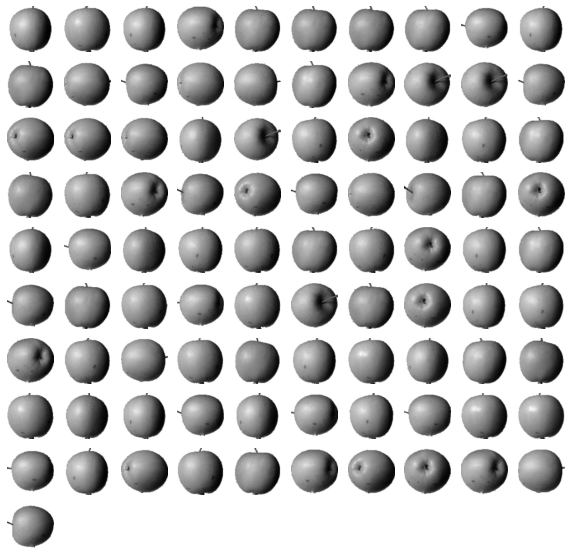

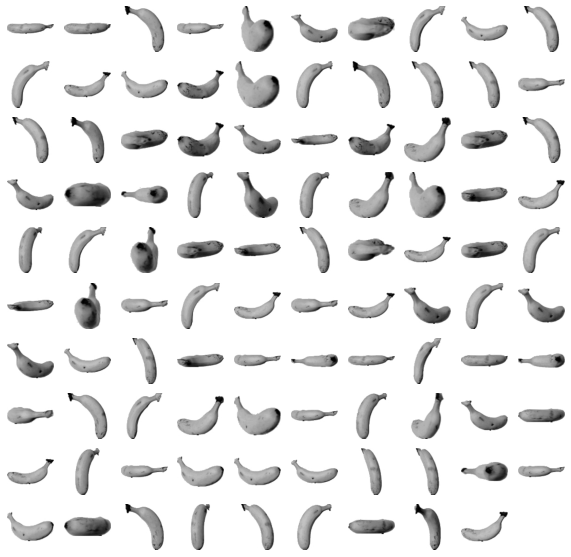

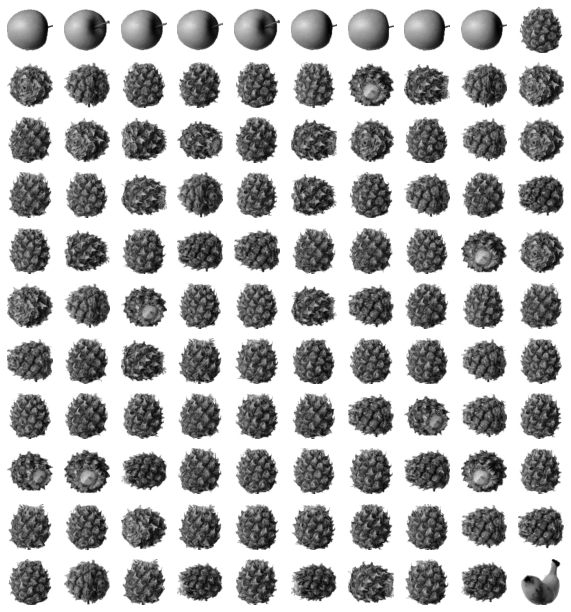

In [25]:
#K-평균을 통해 분류한 이미지를 출력
for label in range(0, 3):
  draw_fruits(fruits[km.labels_ == label])
  print("\n")

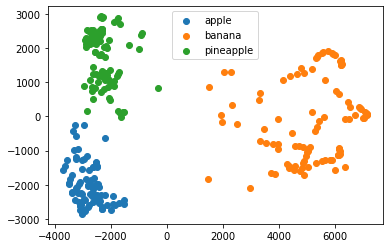

In [26]:
#클러스터별로 나누어 산점도를 그림
for label in range(0, 3):
  data = fruits_pca[km.labels_ == label]
  plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()